SkyGlow : Light Pollution - An AI Analytics to Measure 
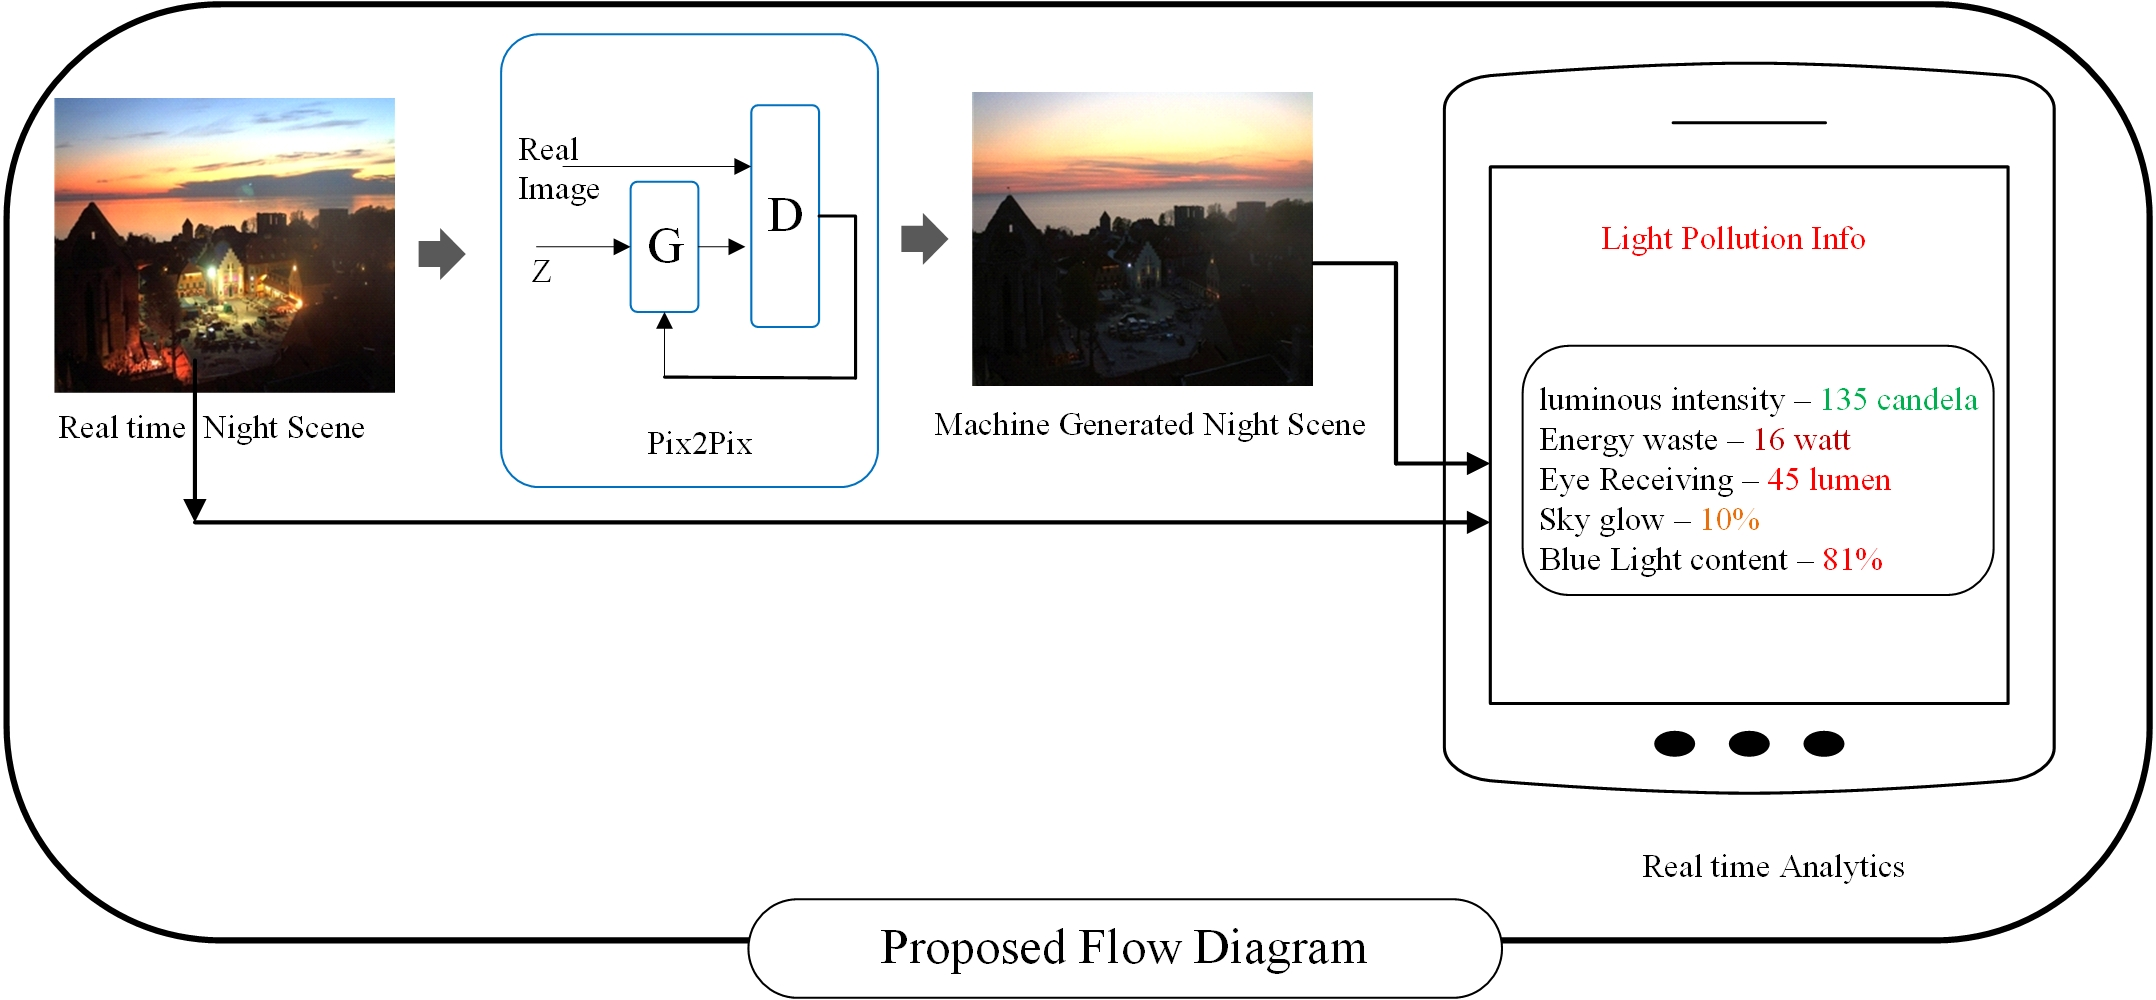

Code to generate Night dark scene:
    
Note: I have learned a model using dataset(http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/) which will take input as light polluted secen and generate corresponding dark image.

Please find below sample:

In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet.gluon.nn import Dense, Activation, Conv2D, Conv2DTranspose, \
    BatchNorm, LeakyReLU, Flatten, HybridSequential, HybridBlock, Dropout
from mxnet import autograd
import numpy as np

D:\Conda\envs\BlurGan\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
epochs = 50
batch_size = 10

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5
lambda1 = 100

pool_size = 50

In [3]:
dataset = 'AB'
img_wd = 256
img_ht = 256
train_img_path = '%s/train' % (dataset)
val_img_path = '%s/val' % (dataset)
test_img_path = '%s/test' % (dataset)

def load_data(path, batch_size, is_reversed=False):
    img_in_list = []
    img_out_list = []
    for path, _, fnames in os.walk(path):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img).astype(np.float32)/127.5 - 1
            img_arr = mx.image.imresize(img_arr, img_wd * 2, img_ht)
            # Crop input and output images
            img_arr_in, img_arr_out = [mx.image.fixed_crop(img_arr, 0, 0, img_wd, img_ht),
                                       mx.image.fixed_crop(img_arr, img_wd, 0, img_wd, img_ht)]
            img_arr_in, img_arr_out = [nd.transpose(img_arr_in, (2,0,1)),
                                       nd.transpose(img_arr_out, (2,0,1))]
            img_arr_in, img_arr_out = [img_arr_in.reshape((1,) + img_arr_in.shape),
                                       img_arr_out.reshape((1,) + img_arr_out.shape)]
            img_in_list.append(img_arr_out if is_reversed else img_arr_in)
            img_out_list.append(img_arr_in if is_reversed else img_arr_out)
    #print(img_in_list)
    return mx.io.NDArrayIter(data=[nd.concat(*img_in_list, dim=0), nd.concat(*img_out_list, dim=0)],
                             batch_size=batch_size)

#download_data(dataset)
train_data = load_data(train_img_path, batch_size, is_reversed=True)
#val_data = load_data(val_img_path, batch_size, is_reversed=True)
#test_data = load_data(test_img_path, batch_size, is_reversed=True)
#print(np.shape(test_data))

In [4]:
def visualizeGT(img_arr,name):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')
    plt.savefig(name,bbox_inches='tight')
    #plt.axis('off')
def visualizeIm(img_arr,name):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')
    plt.savefig(name,bbox_inches='tight')


In [5]:
# Define Unet generator skip block
class UnetSkipUnit(HybridBlock):
    def __init__(self, inner_channels, outer_channels, inner_block=None, innermost=False, outermost=False,
                 use_dropout=False, use_bias=False):
        super(UnetSkipUnit, self).__init__()

        with self.name_scope():
            self.outermost = outermost
            en_conv = Conv2D(channels=inner_channels, kernel_size=4, strides=2, padding=1,
                             in_channels=outer_channels, use_bias=use_bias)
            en_relu = LeakyReLU(alpha=0.2)
            en_norm = BatchNorm(momentum=0.1, in_channels=inner_channels)
            de_relu = Activation(activation='relu')
            de_norm = BatchNorm(momentum=0.1, in_channels=outer_channels)

            if innermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels, use_bias=use_bias)
                encoder = [en_relu, en_conv]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + decoder
            elif outermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2)
                encoder = [en_conv]
                decoder = [de_relu, de_conv, Activation(activation='tanh')]
                model = encoder + [inner_block] + decoder
            else:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2, use_bias=use_bias)
                encoder = [en_relu, en_conv, en_norm]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + [inner_block] + decoder
            if use_dropout:
                model += [Dropout(rate=0.5)]

            self.model = HybridSequential()
            with self.model.name_scope():
                for block in model:
                    self.model.add(block)

    def hybrid_forward(self, F, x):
        if self.outermost:
            return self.model(x)
        else:
            return F.concat(self.model(x), x, dim=1)

# Define Unet generator
class UnetGenerator(HybridBlock):
    def __init__(self, in_channels, num_downs, ngf=64, use_dropout=True):
        super(UnetGenerator, self).__init__()

        #Build unet generator structure
        unet = UnetSkipUnit(ngf * 8, ngf * 8, innermost=True)
        for _ in range(num_downs - 5):
            unet = UnetSkipUnit(ngf * 8, ngf * 8, unet, use_dropout=use_dropout)
        unet = UnetSkipUnit(ngf * 8, ngf * 4, unet)
        unet = UnetSkipUnit(ngf * 4, ngf * 2, unet)
        unet = UnetSkipUnit(ngf * 2, ngf * 1, unet)
        unet = UnetSkipUnit(ngf, in_channels, unet, outermost=True)

        with self.name_scope():
            self.model = unet

    def hybrid_forward(self, F, x):
        return self.model(x)

# Define the PatchGAN discriminator
class Discriminator(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_sigmoid=False, use_bias=False):
        super(Discriminator, self).__init__()

        with self.name_scope():
            self.model = HybridSequential()
            kernel_size = 4
            padding = int(np.ceil((kernel_size - 1)/2))
            self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=in_channels))
            self.model.add(LeakyReLU(alpha=0.2))

            nf_mult = 1
            for n in range(1, n_layers):
                nf_mult_prev = nf_mult
                nf_mult = min(2 ** n, 8)
                self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                      padding=padding, in_channels=ndf * nf_mult_prev,
                                      use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
                self.model.add(LeakyReLU(alpha=0.2))

            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n_layers, 8)
            self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult_prev,
                                  use_bias=use_bias))
            self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
            self.model.add(LeakyReLU(alpha=0.2))
            self.model.add(Conv2D(channels=1, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult))
            if use_sigmoid:
                self.model.add(Activation(activation='sigmoid'))

    def hybrid_forward(self, F, x):
        out = self.model(x)
        #print(out)
        return out

In [6]:
def param_init(param):
    if param.name.find('conv') != -1:
        if param.name.find('weight') != -1:
            param.initialize(init=mx.init.Normal(0.02), ctx=ctx)
        else:
            param.initialize(init=mx.init.Zero(), ctx=ctx)
    elif param.name.find('batchnorm') != -1:
        param.initialize(init=mx.init.Zero(), ctx=ctx)
        # Initialize gamma from normal distribution with mean 1 and std 0.02
        if param.name.find('gamma') != -1:
            param.set_data(nd.random_normal(1, 0.02, param.data().shape))
            
def network_init(net):
    for param in net.collect_params().values():
        param_init(param)

def set_network():
    # Pixel2pixel networks
    netG = UnetGenerator(in_channels=3, num_downs=8)
    netD = Discriminator(in_channels=6)

    # Initialize parameters
    network_init(netG)
    network_init(netD)

    # trainer for the generator and the discriminator
    trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

    return netG, netD, trainerG, trainerD

# Loss
GAN_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
L1_loss = gluon.loss.L1Loss()

netG, netD, trainerG, trainerD = set_network()

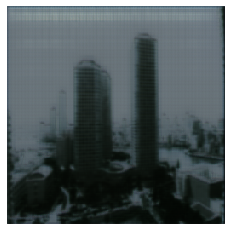

In [7]:
file_name = "net - Copy.paramsND"
#netG.save_parameters(file_name)

new_net = UnetGenerator(in_channels=3, num_downs=8)
new_net.load_parameters(file_name, ctx=ctx)
img_in_list, img_out_list = train_data.next().data
#print(np.shape(img_in_list))
#xx

def print_result(i,nameGT,nameIm):
    img_in = nd.expand_dims(img_in_list[i], axis=0)
    img_out = new_net(img_in.as_in_context(ctx))
    visualizeIm(img_in[0],nameIm)
    visualizeGT(img_out[0],nameGT)

num_image = 1
   
for i in range(num_image):
    nameGT = 'blur' + str(i+204) + '.png'
    nameIm = 'Image' + str(i+204) + '.png'
    print_result(i,nameGT,nameIm)

Sample dark secne of a light polluted building